# Indexing
This notebook contains the work for the indexing part of the assignment

Before indexing, we ran the following query as stated in the assignment:

```sql
SELECT DISTINCT p.full_name
FROM (titles t JOIN cast_info ci ON t.title_id = ci.title_id)
JOIN persons p ON ci.person_id = p.person_id
WHERE (t.primary_title = 'Star Wars: Episode IV - A New Hope')
```

The title was changed from `Star Wars: Episode IV- A New Hope` to `Star Wars: Episode IV - A New Hope` as the prior led to 0 results being found the query resulted in the following table:
|Id | full_name|
|--|------------|
|1 |"Aaron Elliott"|
|2|"Alec Guinness"|
|3|"Calvin Grubb"|
|4|"Carrie Fisher"|
|5|"Doug Walker"|
|6|"Eric Whiteley"|
|7|"Gary Kurtz"|
|8|"Gilbert Taylor"|
|9|"Harrison Ford"|
|10|"John Williams"|
|11|"Mark Hamill"|
|12|"Richard Chew"|
|13|"Richard Martin"|
|14|"Rick McCallum"|
|15|"Ryan George"|
|16|"Shane Farley"|
|17|"Walter Banasiak"|

The query took 02 minutes and 46.009 in `EXPLAIN-ANALYZE` mode.


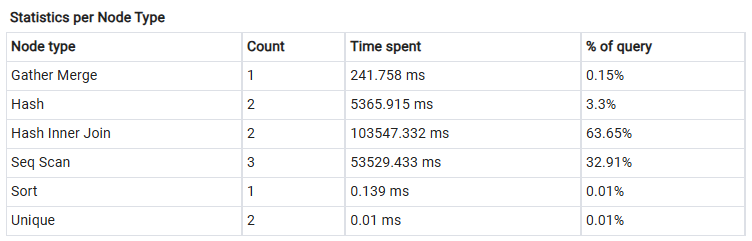

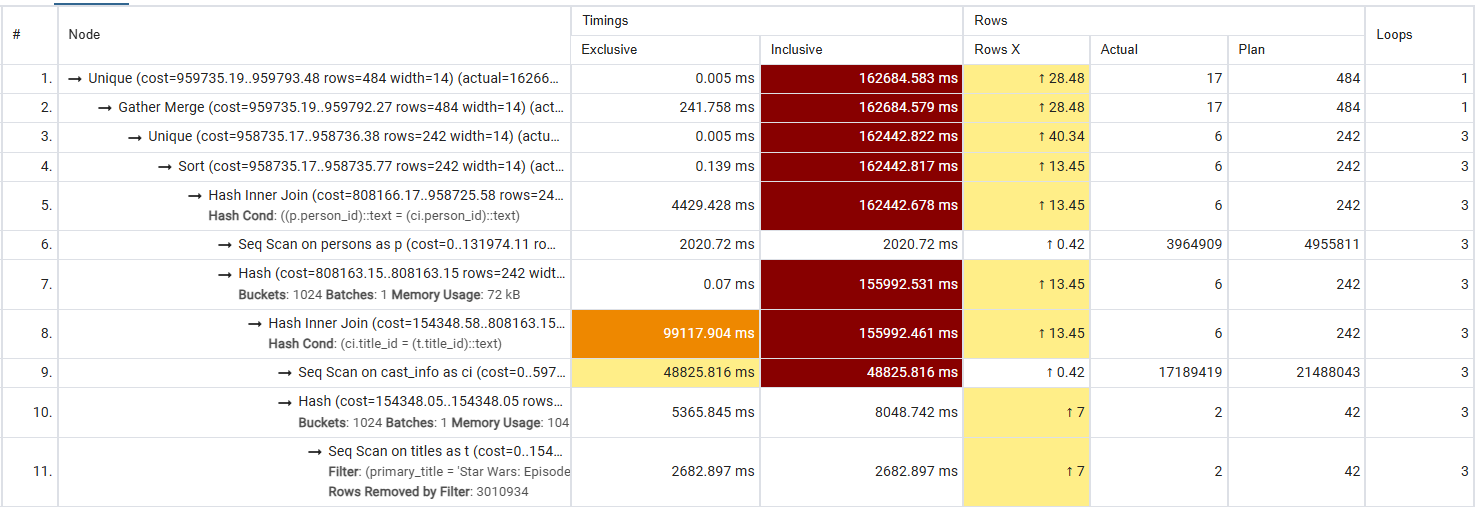


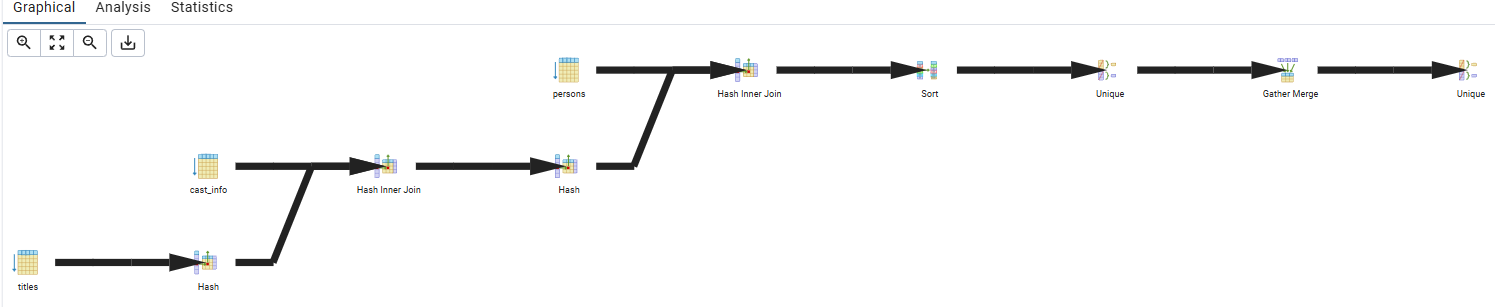




## Making things go faster

To improve the performance we will be using indices. More particularly, we will be using Hash Indices. We will use indices for:
* `titles(primary_title)`
* `cast_info(person_id)`
* `persons(person_id)`

The reason we will be using a hash index for all these and not a B+Tree is due to the fact that none of these are ranged queries, hence hash indices are better suited.

The following commands were used:

```sql
CREATE INDEX idx_primary_title_hash 
ON titles USING hash (primary_title)

CREATE INDEX idx_titles_title_id
ON titles USING hash (title_id)

CREATE INDEX idx_persons_person_id_hash 
ON persons USING hash (person_id)

CREATE INDEX idx_cast_info_person_id_hash 
ON cast_info USING hash (person_id)

CREATE INDEX idx_cast_info_title_id_hash 
ON cast_info USING hash (title_id)
```

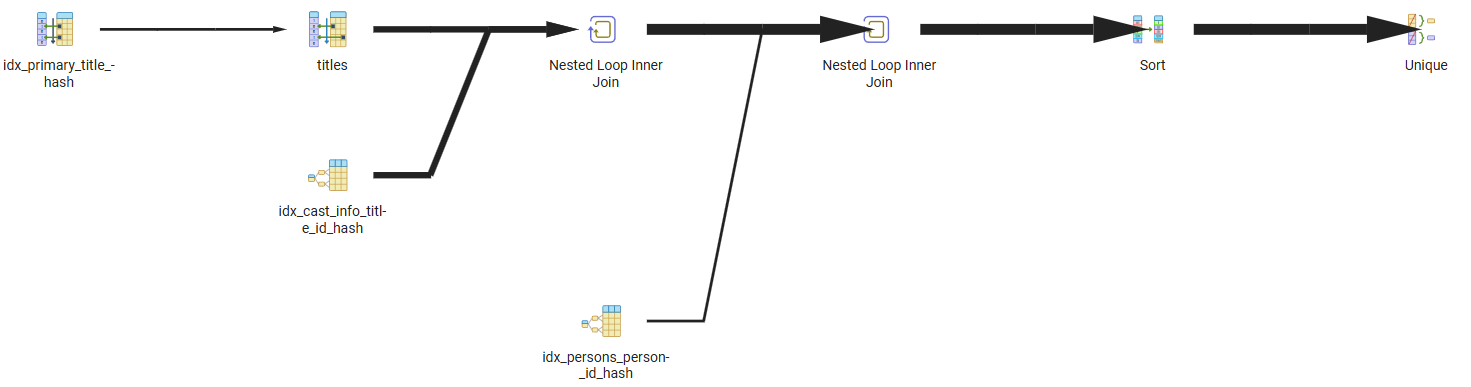

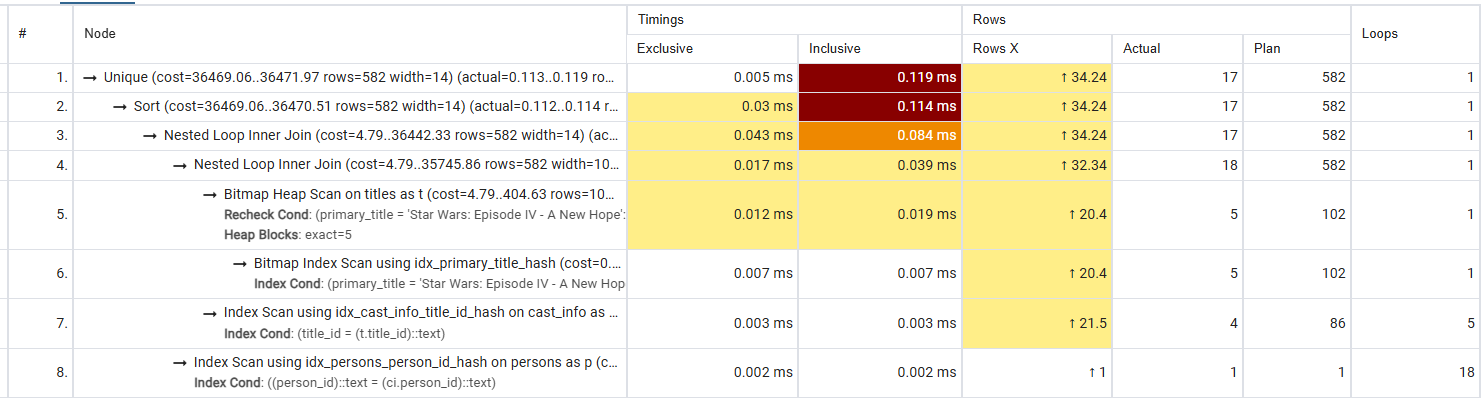

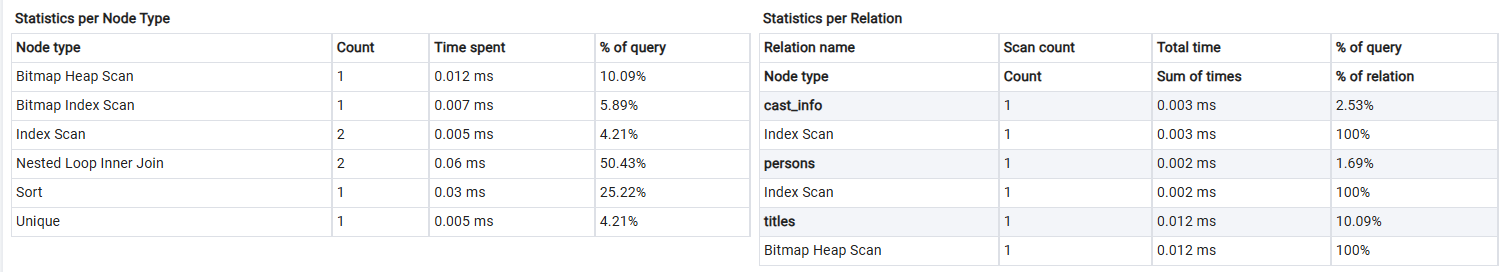

As we can see, with these changes, the time is reduced to 0.090 seconds, which is pretty good.

## Fixing up the database

We can see that each title can be of the following types:
* "movie"
* "short"
* "tvEpisode"
* "tvMiniSeries"
* "tvMovie"
* "tvPilot"
* "tvSeries"
* "tvShort"
* "tvSpecial"
* "video"
* "videoGame"

Hence, a series and a series episode are both _titles_ and should be foreign keys.

When we try the following: 

```sql
ALTER TABLE episodes
ADD FOREIGN KEY (episode_id)
REFERENCES titles (title_id)
```

It doesn't work sadly as there are episode ids that are not in the titles table so those need to be removed. We can remove them using:

```sql
DELETE FROM episodes WHERE episode_id in (
    SELECT episode_id FROM (episodes LEFT JOIN titles on titles.title_id = episodes.episode_id)  
	WHERE titles.title_id is NULL)
```


Now we can run the previous ALTER command to create the first FK.

When we try to make the `series_id` be a FK to `title_id` with the following:
```sql
ALTER TABLE episodes
ADD FOREIGN KEY (series_id)
REFERENCES titles (title_id)
```
we also get a similar error: `ERROR:  insert or update on table "episodes" violates foreign key constraint "episodes_series_id_fkey" Key (series_id)=(tt0086748) is not present in table "titles". `

Which we can fix by dropping the entries with `series_id`s that do not correspond to a `title_id` with the following:
```sql
DELETE FROM episodes WHERE series_id in (
    SELECT series_id FROM (episodes LEFT JOIN titles on titles.title_id = episodes.series_id)  
	WHERE titles.title_id is NULL)
```

Now we can safely make our foreign key with the previous alter command.


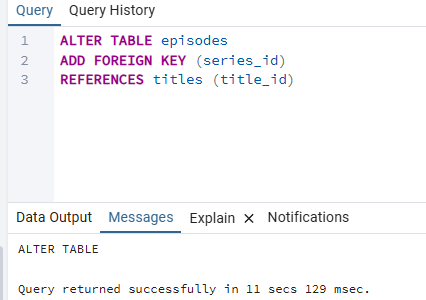

## Running it back

To now do the same query using python we will use PythonDask. To install it we used

```cmd
pip install "dask[complete]"
```

We will also use pandas to benchmark single threaded operations.
```cmd
pip install pandas
```


In [1]:
import pandas as pd
import dask.dataframe as dd
import dask.multiprocessing as dask
import time

In [14]:
def get_indexed_dframes():
    start = time.time()
    titles = dd.read_csv("titles.csv",usecols=["title_id","primary_title"]).set_index("title_id")
    cast_info = dd.read_csv("cast_info.csv",usecols=["title_id","person_id"]).set_index("title_id")
    persons = dd.read_csv("persons.csv",usecols=["person_id","full_name"]).set_index("person_id")
    end = time.time()
    
    print( f"Loading CSVs took {(end-start):.4f} seconds" )

    return titles, cast_info, persons

In [3]:
def run_query_with_processes(titles, cast_info, persons):
    """
    Run the query using Dask with multiprocessing scheduler.
    """

    duration = 0
    
    result = titles.query("primary_title == 'Star Wars: Episode IV - A New Hope'")
    result = result.merge( cast_info, how="inner" )
    
    start = time.time()
    result = result.persist()
    duration = time.time() - start
    
    result = result.set_index("person_id")
    result = result.merge( persons, how="inner" )
    result = result[["full_name"]].drop_duplicates()
    
    start = time.time()
    result = result.compute()
    duration = duration + time.time() - start
    return duration, result

In [15]:
titles, cast_info, persons = get_indexed_dframes()
print( type(titles), type(cast_info), type(persons) )

Loading CSVs took 0.0168 seconds
<class 'dask.dataframe.dask_expr._collection.DataFrame'> <class 'dask.dataframe.dask_expr._collection.DataFrame'> <class 'dask.dataframe.dask_expr._collection.DataFrame'>


In [16]:
elapsed_time, result = run_query_with_processes(titles, cast_info, persons)
print(f"Elapsed time with parallel processes: {elapsed_time} seconds")
print(f"Result {result}")

Elapsed time with parallel processes: 119.83780765533447 seconds
Result                   full_name
person_id                  
nm0156816      Richard Chew
nm9981596     Eric Whiteley
nm9981601     Aaron Elliott
nm0000027     Alec Guinness
nm4489117       Ryan George
nm5366481   Walter Banasiak
nm10354627   Richard Martin
nm3766090       Doug Walker
nm0002354     John Williams
nm0476030        Gary Kurtz
nm9981597      Shane Farley
nm0000402     Carrie Fisher
nm0000148     Harrison Ford
nm0000434       Mark Hamill
nm0852405    Gilbert Taylor
nm0564768     Rick McCallum
nm10354626     Calvin Grubb


In [12]:
def single_process_query():
    titles = pd.read_csv("titles.csv",usecols=["title_id","primary_title"]).set_index("title_id")
    cast_info = pd.read_csv("cast_info.csv",usecols=["title_id","person_id"]).set_index("title_id")
    persons = pd.read_csv("persons.csv",usecols=["person_id","full_name"]).set_index("person_id")

    start = time.time()
    result = titles.query("primary_title == 'Star Wars: Episode IV - A New Hope'")
    result = result.merge( cast_info, how="inner", left_index=True, right_index=True )
    result = result.set_index("person_id")
    result = result.merge( persons, how="inner", left_index=True, right_index=True )
    result = result[["full_name"]].drop_duplicates()
    duration = time.time() - start
    
    return duration, result

In [13]:
elapsed_time, result = single_process_query()
print(f"Elapsed time for serial execution: {elapsed_time} seconds")
print(f"Result {result}")

Elapsed time for serial execution: 17.882814645767212 seconds
Result                   full_name
person_id                  
nm4489117       Ryan George
nm10354626     Calvin Grubb
nm10354627   Richard Martin
nm9981596     Eric Whiteley
nm9981597      Shane Farley
nm9981601     Aaron Elliott
nm3766090       Doug Walker
nm5366481   Walter Banasiak
nm0000027     Alec Guinness
nm0000148     Harrison Ford
nm0000402     Carrie Fisher
nm0000434       Mark Hamill
nm0002354     John Williams
nm0156816      Richard Chew
nm0476030        Gary Kurtz
nm0564768     Rick McCallum
nm0852405    Gilbert Taylor
